In [ ]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

### Read in images, resize and save then create train, test and validation data frames

In [ ]:
def make_dataframes(sdir, img_size):
    working_dir=r'./'
    dstdir=os.path.join(working_dir, 'resized')
    if os.path.isdir(dstdir):
        shutil.rmtree(dstdir)
    os.mkdir(dstdir)
    filepaths=[]
    labels=[]
    plant_list=sorted(os.listdir(sdir) )
    for plant in plant_list:
        plant_path=os.path.join(sdir, plant)
        dst_plant_path=os.path.join(dstdir, plant)
        os.mkdir(dst_plant_path)
        classlist=sorted(os.listdir(plant_path))
        for klass in classlist:
            classpath=os.path.join(plant_path, klass)
            dst_classpath=os.path.join(dst_plant_path, klass)
            os.mkdir(dst_classpath)
            flist=sorted(os.listdir(classpath))
            desc=f'{plant:25s}-{klass:9s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                dst_fpath=os.path.join(dst_classpath,f)
                filepaths.append(dst_fpath)
                img=cv2.imread(fpath)
                img=cv2.resize(img, img_size)
                cv2.imwrite(dst_fpath, img)
                labels.append(plant + '-' + klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    print('number of classes in processed dataset= ', class_count)
    counts=list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    return train_df, test_df, valid_df, classes, class_count

sdir=r'../input/plant-leaves-for-image-classification'
img_size=(200,300)
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir, img_size)

Pongamia Pinnata (P7)    -healthy  : 100%|███████████████████████████████████████████████████| 322/322 [01:42<00:00,  3.14files/s]

number of classes in processed dataset=  22
the maximum files in any class in train_df is  242   the minimum files in any class in train_df is  54
train_df length:  3151   test_df length:  676   valid_df length:  675


### Trim train_df so no class has more than max_samples images

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=200
min_samples=54
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  3151  with  22  classes
after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  54
the trimmed dataframe now is of length  3083  with  22  classes


### Expand train_df rows with augmented images so each class has 200 samples

In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,300) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  3083
Found 195 validated image filenames.     for class       Jamun (P5)-healthy       creating   5   augmented images 
Found 190 validated image filenames.     for class   Pomegranate (P9)-diseased    creating  10   augmented images 
Found 84 validated image filenames.      for class     Chinar (P11)-diseased      creating  116  augmented images 
Found 178 validated image filenames.     for class Alstonia Scholaris (P2)-diseased creating  22   augmented images 
Found 93 validated image filenames.      for class     Jatropha (P6)-healthy      creating  107  augmented images 
Found 119 validated image filenames.     for class       Mango (P0)-healthy       creating  81   augmented images 
Found 194 validated image filenames.     for class       Gauva (P3)-healthy       creating   6   augmented images 
Found 104 validated image filenames.     for class       Basil (P8)-healthy       creating  96   augmented images 
Found 154 validated image filenames.     

### Create the train_gen, test_gen final_test_gen and valid_gen

In [ ]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

batch_size=20
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 4400 validated image filenames belonging to 22 classes.          for train generator 
Found 675 validated image filenames belonging to 22 classes.           for valid generator 
Found 676 validated image filenames belonging to 22 classes.           for test generator 
test batch size:  52   test steps:  13  number of classes :  22


### Create a function to show example training images

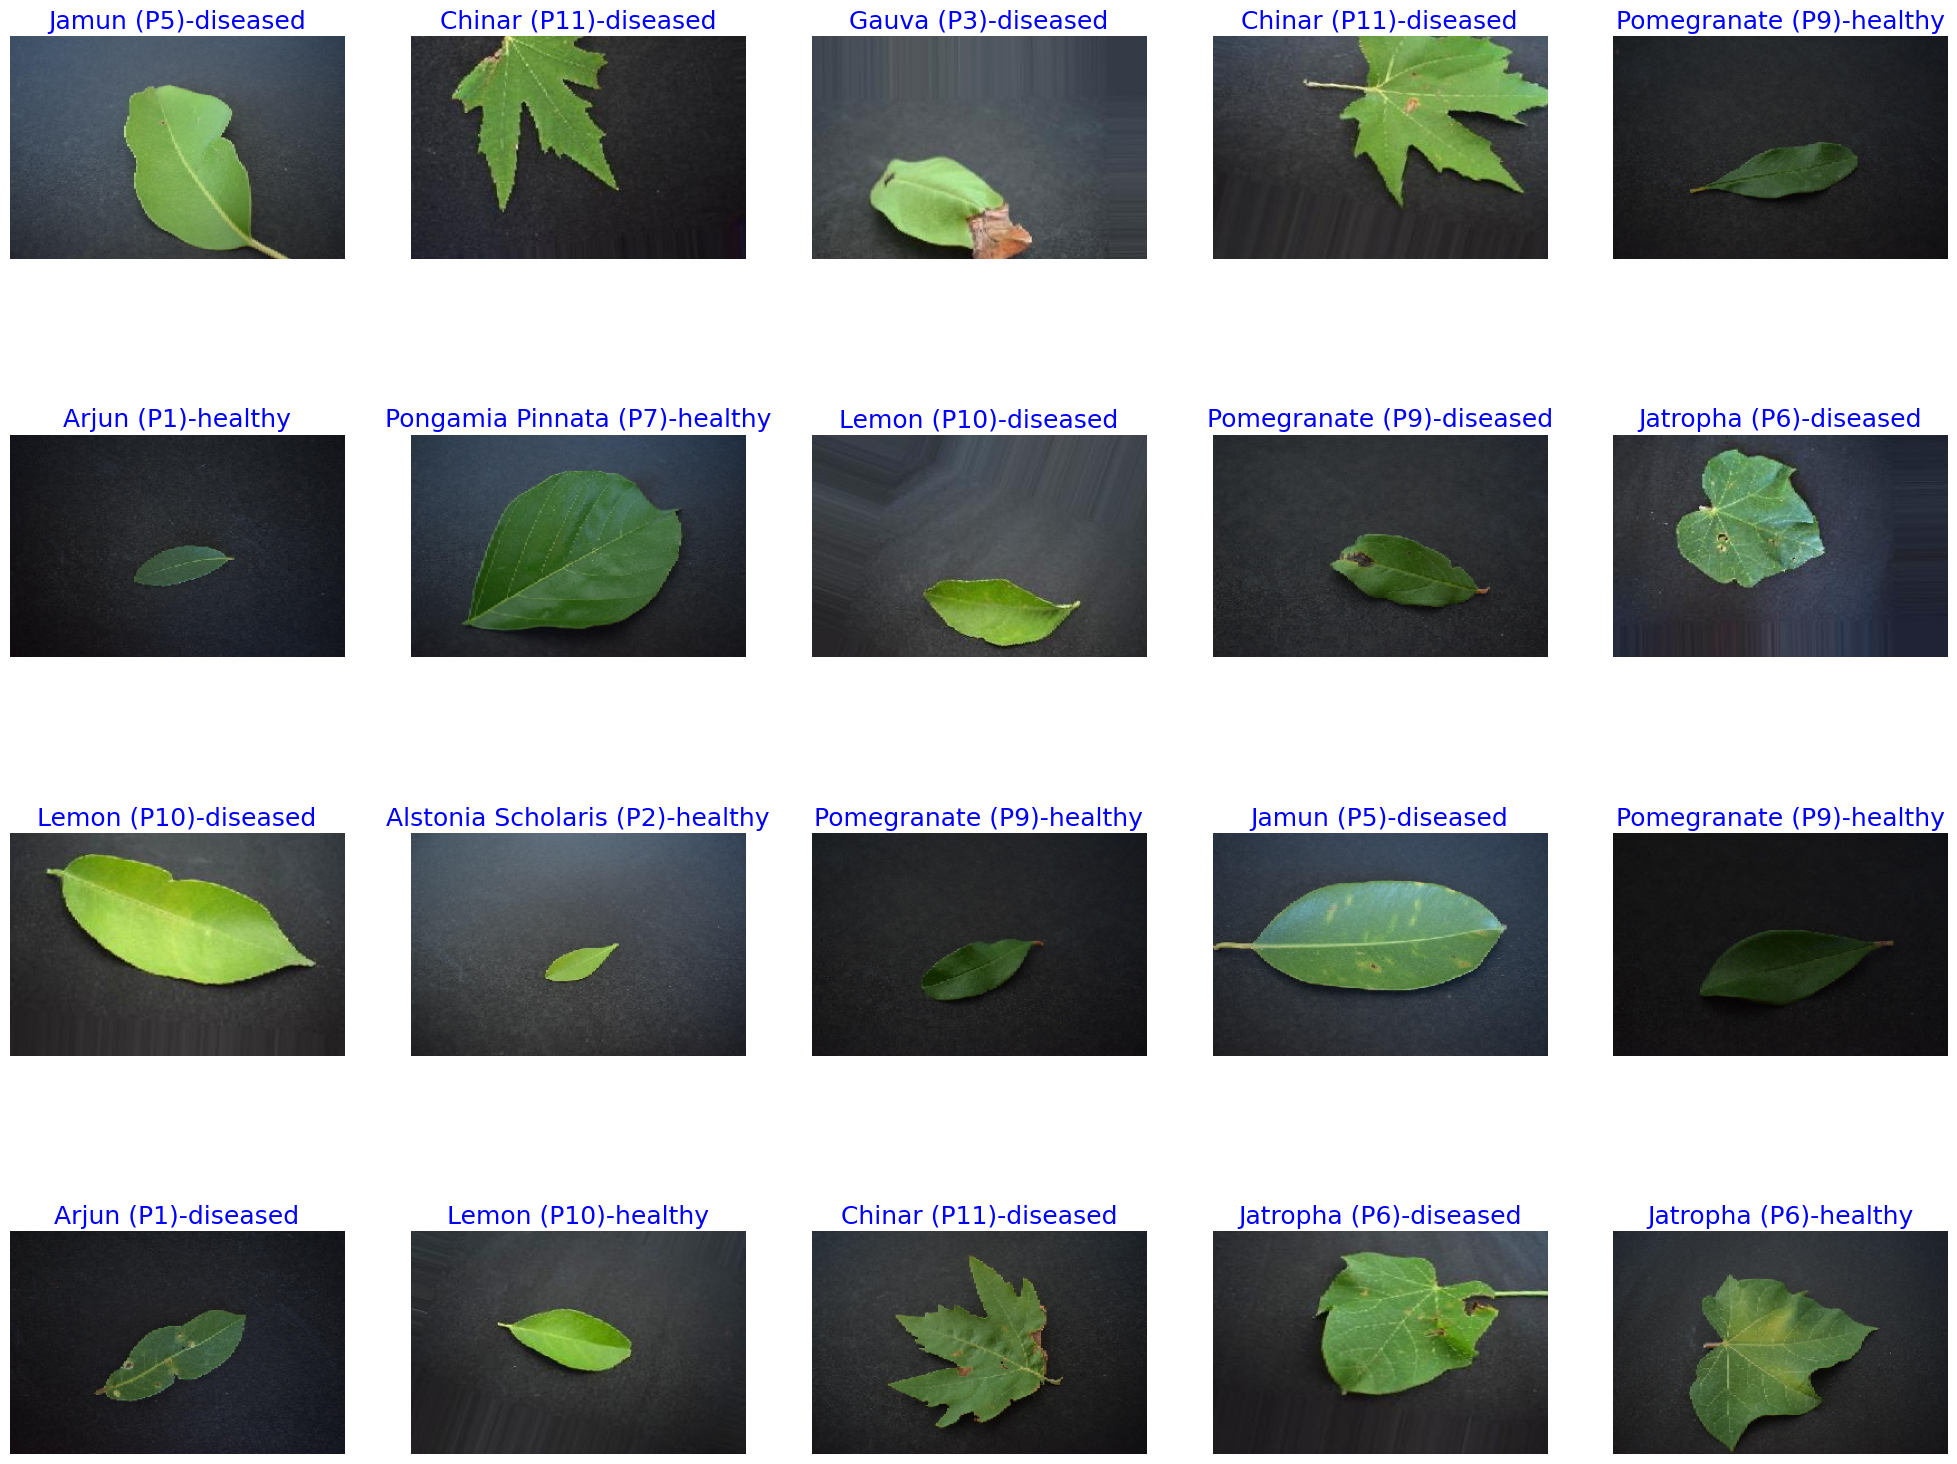

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )

### Building the Model

In [ ]:
img_shape=(img_size[0], img_size[1], 3)
# Build a custom sequential CNN model

model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[img_size[0], img_size[1], 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 37, 32)       0

### Train the model

In [ ]:
# Compile and fit the model
history = model.fit(train_gen, epochs=40, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=False,  initial_epoch=0)

Epoch 1/40
220/220 [==============================] - 19s 45ms/step - loss: 3.5909 - accuracy: 0.1114 - val_loss: 2.3449 - val_accuracy: 0.2593
Epoch 2/40
220/220 [==============================] - 9s 42ms/step - loss: 2.3187 - accuracy: 0.2711 - val_loss: 1.6555 - val_accuracy: 0.4904
Epoch 3/40
220/220 [==============================] - 9s 41ms/step - loss: 1.8895 - accuracy: 0.3977 - val_loss: 1.3984 - val_accuracy: 0.5363
Epoch 4/40
220/220 [==============================] - 9s 39ms/step - loss: 1.5667 - accuracy: 0.4814 - val_loss: 1.1496 - val_accuracy: 0.6030
Epoch 5/40
220/220 [==============================] - 9s 40ms/step - loss: 1.3733 - accuracy: 0.5384 - val_loss: 1.1541 - val_accuracy: 0.6341
Epoch 6/40
220/220 [==============================] - 9s 43ms/step - loss: 1.1768 - accuracy: 0.5884 - val_loss: 0.9210 - val_accuracy: 0.7052
Epoch 7/40
220/220 [==============================] - 10s 43ms/step - loss: 1.0333 - accuracy: 0.6498 - val_loss: 0.8448 - val_accuracy: 0.70

### Define a function to plot the training data

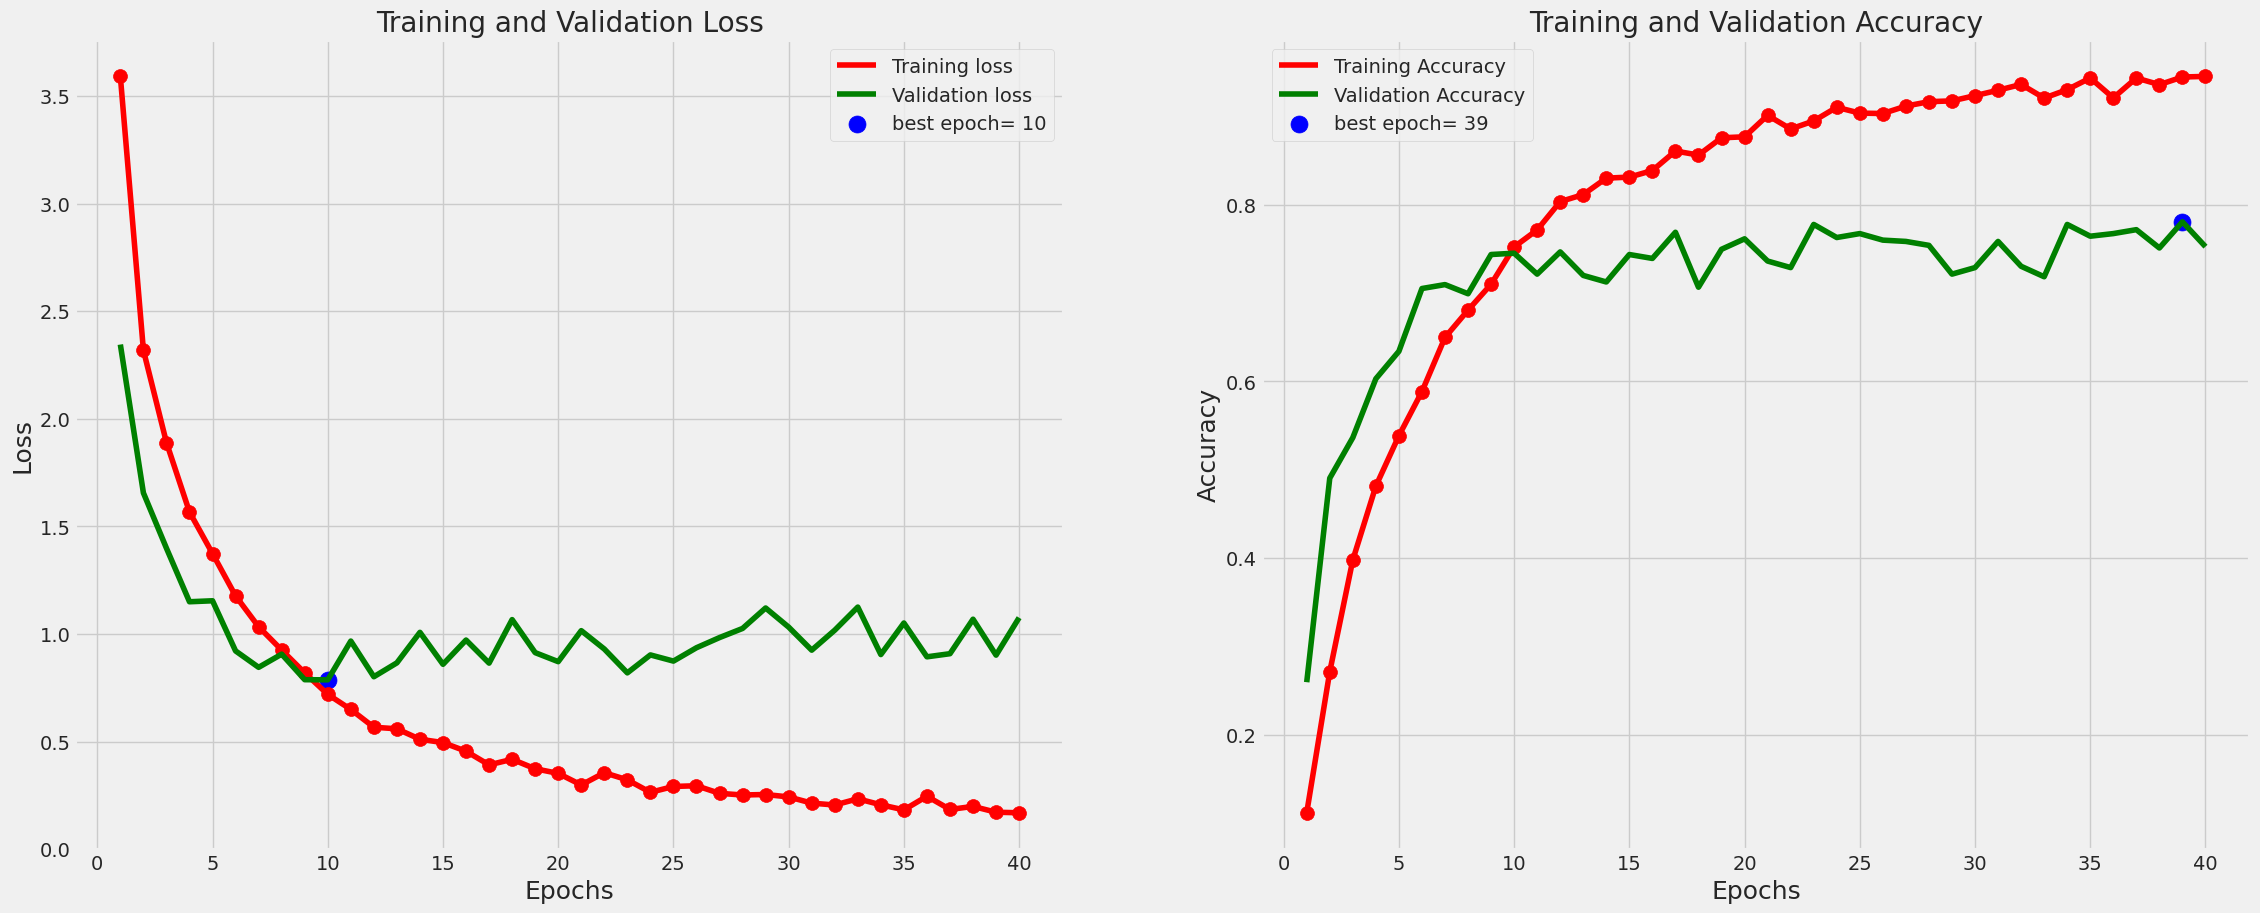

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout
    plt.show()
    return index_loss

loss_index=tr_plot(history,0)

### Make Predictions on the test set

13/13 [==============================] - 2s 114ms/step
there were 188 errors in 676 tests for an accuracy of  72.19


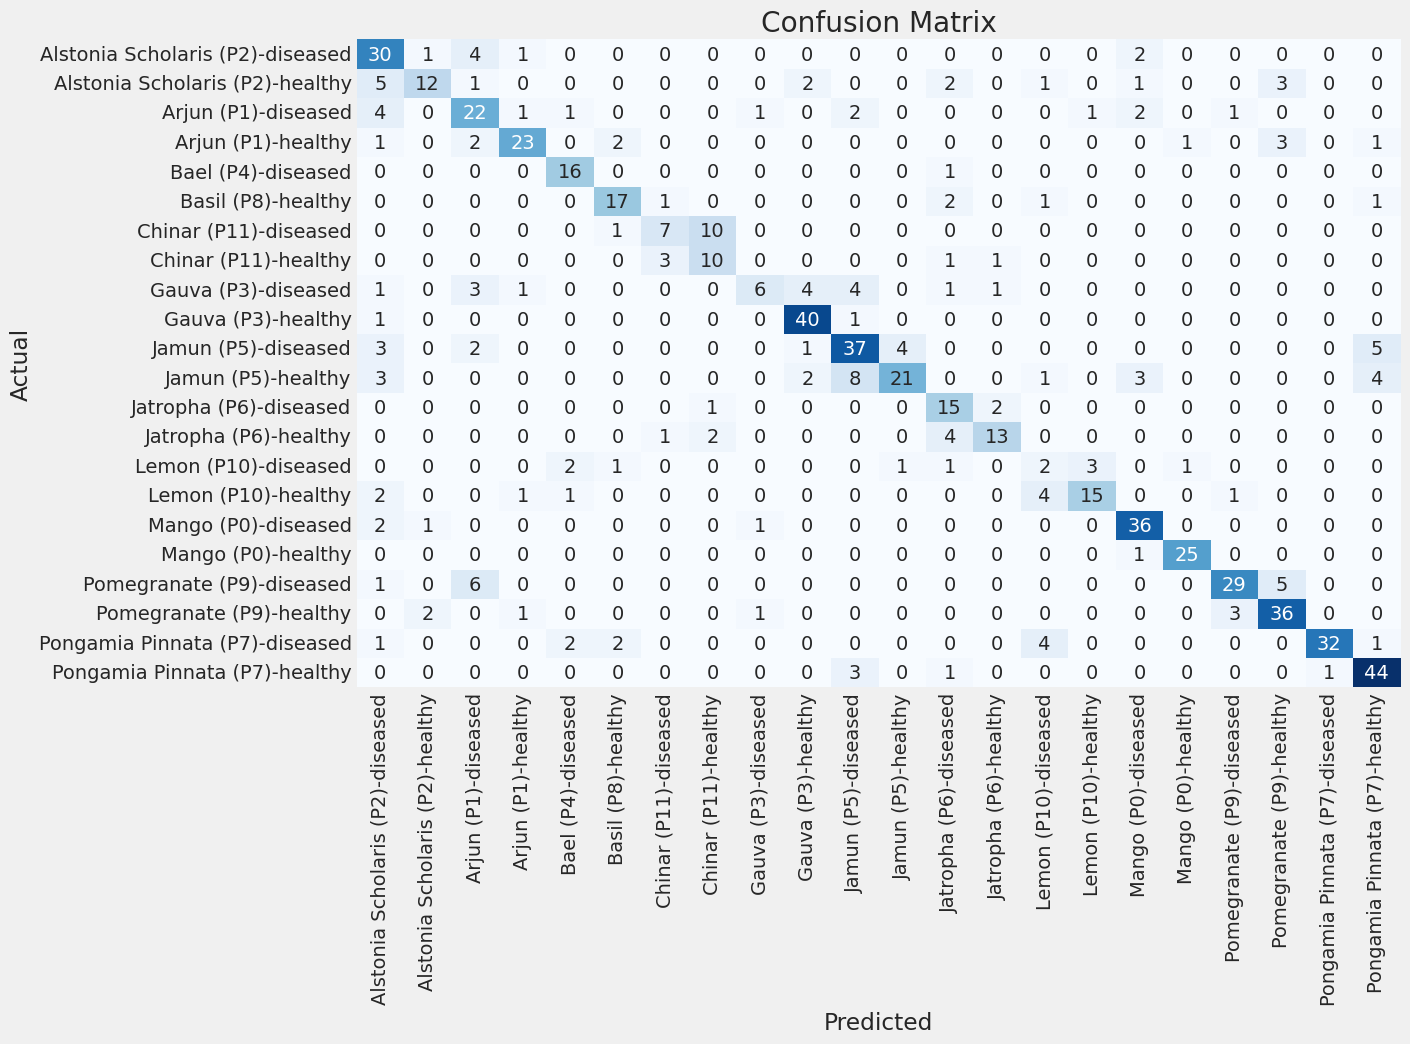

Classification Report:
----------------------
                                   precision    recall  f1-score   support

Alstonia Scholaris (P2)-diseased     0.5556    0.7895    0.6522        38
 Alstonia Scholaris (P2)-healthy     0.7500    0.4444    0.5581        27
             Arjun (P1)-diseased     0.5500    0.6286    0.5867        35
              Arjun (P1)-healthy     0.8214    0.6970    0.7541        33
              Bael (P4)-diseased     0.7273    0.9412    0.8205        17
              Basil (P8)-healthy     0.7391    0.7727    0.7556        22
           Chinar (P11)-diseased     0.5833    0.3889    0.4667        18
            Chinar (P11)-healthy     0.4348    0.6667    0.5263        15
             Gauva (P3)-diseased     0.6667    0.2857    0.4000        21
              Gauva (P3)-healthy     0.8163    0.9524    0.8791        42
             Jamun (P5)-diseased     0.6727    0.7115    0.6916        52
              Jamun (P5)-healthy     0.8077    0.5000    0.6176 

In [ ]:
def predictor(test_gen):
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        file=test_gen.filenames[i]
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score,

errors, tests, error_list, f1score, class_labels =predictor(test_gen)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Save & Load the model

In [ ]:
from keras.models import model_from_json

# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to h5 file
model.save_weights("model_weights.h5")

print("Model saved to disk.")

In [ ]:
from keras.models import model_from_json

# Load the model architecture from JSON
with open("/content/gdrive/MyDrive/Colab Notebooks/research/data/tea-classifier/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights
loaded_model.load_weights("/content/gdrive/MyDrive/Colab Notebooks/research/data/tea-classifier/model_weights.h5")

print("Model loaded from disk.")

Model loaded from disk.


### Prediction

In [ ]:
def predict_leaf(image_path):
    image = cv2.imread(image_path)
    # Resize the image to match the input size expected by the model
    resized_image = cv2.resize(image, (300, 200))
    input_image = np.expand_dims(resized_image, axis=0)

    # Make a prediction using the loaded model
    predictions = loaded_model.predict(input_image)
    predicted_class_index = np.argmax(predictions[0])

    # Retrieve the predicted emotion label
    predicted_leaf = class_labels[predicted_class_index]
    return predicted_leaf

In [ ]:
predict_leaf('/content/gdrive/MyDrive/Colab Notebooks/research/data/Plants_2/images to predict/0001_0170.JPG')

1/1 [==============================] - 1s 611ms/step


NameError: ignored

### Interface

In [ ]:
%%capture
!pip install gradio

In [ ]:
import gradio as gr

demo = gr.Interface(
    predict_leaf,
    input=gr.Image(type="pil"),
    output=gr.Text('text')
    "image",
#     flagging_options=["blurry", "incorrect", "other"],
#     examples=[
#         os.path.join(os.path.dirname(__file__), "images/cheetah1.jpg"),
#         os.path.join(os.path.dirname(__file__), "images/lion.jpg"),
#         os.path.join(os.path.dirname(__file__), "images/logo.png"),
#         os.path.join(os.path.dirname(__file__), "images/tower.jpg"),
#     ],
)